# Medicare Fraud Detection

### Data 698: Data Science Research Project - Spring 2019

### Student: Chunhui Zhu

Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2016.csv: https://data.cms.gov/Medicare-Physician-Supplier/Medicare-Provider-Utilization-and-Payment-Data-Phy/utc4-f9xp

LEIE2019.csv: https://oig.hhs.gov/exclusions/exclusions_list.asp

## Continouse from Part IV

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib as plt
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

import pickle
from math import isnan

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

from sklearn.metrics import classification_report

### Obsert from last step "convt2016_pickle"

In [2]:
df_pkl=open("convt_dropcolumns_2016_pickle","rb")
df2016=pickle.load(df_pkl)
df_pkl.close()

In [3]:
df2016.head()

,npi,type,hcpcs_c,line_srvc_cnt,bene_day_srvc_cnt,avg_submitted_chrg_amt,city,state,Fraud
1,1003000126,0.0,99217,57.0,57.0,325.157895,3,2,0
2,1003000126,0.0,99219,38.0,38.0,614.000000,3,2,0
3,1003000126,0.0,99220,23.0,23.0,769.347826,3,2,0
4,1003000126,0.0,99221,20.0,20.0,460.000000,3,2,0
5,1003000126,0.0,99222,96.0,96.0,625.000000,3,2,0


## Prepare for Training set and Test set

### Use 2012-2015 as training data set, 2016 as testing data set

In [4]:
#example pickle name df13_pickle
def loaddf (year):
    y=str(year)
    df_pkl=open("convt_dropcolumns_"+str(year)+"_pickle","rb")
    df=pickle.load(df_pkl)
    print("The number of rows in data set " + "convt_dropcolumns_"+str(year)+"_pickle" +" is " + str(len(df)) + ".")
    df_pkl.close()
    
    print("Broke down fraud and non-fraud data set.")
    df_fraud_0 = df[df['Fraud'] == 0]
    df_fraud_1 = df[df['Fraud'] == 1]
    return (df_fraud_0, df_fraud_1)


In [5]:
fraud2016_0, fraud2016_1, =loaddf(2016)
fraud2015_0, fraud2015_1, =loaddf(2015)
fraud2014_0, fraud2014_1, =loaddf(2014)
fraud2013_0, fraud2013_1, =loaddf(2013)
fraud2012_0, fraud2012_1, =loaddf(2012)

The number of rows in data set convt_dropcolumns_2016_pickle is 7776378.
Broke down fraud and non-fraud data set.
The number of rows in data set convt_dropcolumns_2015_pickle is 8817549.
Broke down fraud and non-fraud data set.
The number of rows in data set convt_dropcolumns_2014_pickle is 8725103.
Broke down fraud and non-fraud data set.
The number of rows in data set convt_dropcolumns_2013_pickle is 8700666.
Broke down fraud and non-fraud data set.
The number of rows in data set convt_dropcolumns_2012_pickle is 8608644.
Broke down fraud and non-fraud data set.


In [6]:
fraud2012to2015_0= [fraud2015_0,fraud2014_0,fraud2013_0,fraud2012_0]
df_fraud2012to2015_0=pd.concat(fraud2012to2015_0)
print(len(df_fraud2012to2015_0))

34814662


In [7]:
fraud2012to2015_1= [fraud2015_1,fraud2014_1,fraud2013_1,fraud2012_1]
df_fraud2012to2015_1=pd.concat(fraud2012to2015_1)
print(len(df_fraud2012to2015_1))

37300


### Exclude 2016 sampling data from 2012-2015 training set

#### Ended in 2015, there is unkonw for the fraud in 2016. I exclusive the 2016 fraud from df_fraud2012to2015_1 data set.

In [8]:
df_fraud2012to2015_1_only=df_fraud2012to2015_1[~df_fraud2012to2015_1.npi.isin(fraud2016_1.npi.unique())]
len(df_fraud2012to2015_1_only)

23182

In [9]:
df_2012to2015=pd.concat([df_fraud2012to2015_0,df_fraud2012to2015_1_only],axis=0)
len(df_2012to2015)

34837844

#### Random sampling 1 million data from 2016 as test data, and exclusive them from training data set

In [10]:
#random sampling 1 Million non-fraud ID from 
test_2016_samples= df2016.sample(1000000, replace=True)

In [11]:
df_2012to2015_only=df_2012to2015[~df_2012to2015.npi.isin(test_2016_samples.npi.unique())]
len(df_2012to2015_only)

12539424

### Ramdom Shuffle all rows using sample()

In [12]:
train_2012to2015_shuffle=df_2012to2015_only.sample( frac = 1 )
test_2016_shuffle=test_2016_samples.sample( frac = 1 )

#### Drop "npi" & "hcpcs_c"

In [13]:
train_2012to2015_shuffle=train_2012to2015_shuffle.drop(['npi','hcpcs_c'],axis=1)
test_2016_shuffle = test_2016_shuffle.drop(['npi', 'hcpcs_c'],axis=1)

Fraud 0: 12516242
Fraud 1: 23182
Proportion: 539.91 : 1


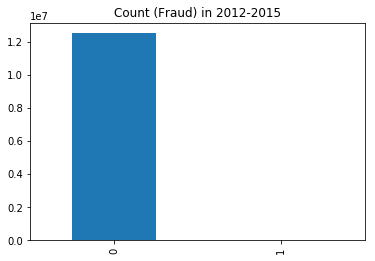

In [14]:
fraud_count = train_2012to2015_shuffle.Fraud.value_counts()
print('Fraud 0:', fraud_count[0])
print('Fraud 1:', fraud_count[1])
print('Proportion:', round(fraud_count[0] / fraud_count[1], 2), ': 1')

fraud_count.plot(kind='bar', title='Count (Fraud) in 2012-2015');

## Imbalanced-learn module - Over Sampling SMOTE

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [16]:
x_train=train_2012to2015_shuffle.drop(['Fraud'],axis = 1)
y_train=train_2012to2015_shuffle[['Fraud']]

sm = SMOTE(random_state=12, ratio = 1.0)
x_train_resample, y_train_resample = sm.fit_sample(x_train,y_train)

C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
df_y_train_resample=pd.DataFrame(y_train_resample)
df_x_train_resample=pd.DataFrame(x_train_resample)
aftersample_2012to2015=pd.concat([df_x_train_resample, df_y_train_resample],axis=1)

Fraud 0: 12516242
Fraud 1: 12516242
Proportion: 1.0 : 1


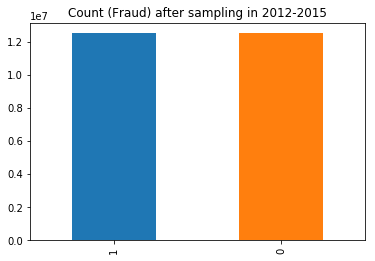

In [18]:
fraud_count_aftersample = aftersample_2012to2015.iloc[:,-1].value_counts()
print('Fraud 0:', fraud_count_aftersample [0])
print('Fraud 1:', fraud_count_aftersample [1])
print('Proportion:', round(fraud_count_aftersample [0] / fraud_count_aftersample [1], 2), ': 1')

fraud_count_aftersample.plot(kind='bar', title='Count (Fraud) after sampling in 2012-2015');

In [19]:
# Randomly sample 25% of train dataframe
df_x_train_resample_25perc = df_x_train_resample.sample(frac=0.25)
df_y_train_resample_25perc = df_y_train_resample.sample(frac=0.25)

### Random Forest 

In [21]:
clf_rf = RandomForestClassifier(n_estimators = 25, random_state = 12)
clf_rf.fit(df_x_train_resample_25perc, df_y_train_resample_25perc.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [34]:
x_test_2016 = test_2016_samples.drop(['npi','hcpcs_c','Fraud'],axis=1)
y_test_2016 = test_2016_samples[['Fraud']]

In [38]:
x_test_2016.head()

,type,line_srvc_cnt,bene_day_srvc_cnt,avg_submitted_chrg_amt,city,state
87966,3.0,38.0,23.0,1796.631579,4,0
1622439,4.0,23.0,23.0,155.000000,3,1
5884493,2.0,47.0,47.0,300.000000,4,0
3930271,2.0,72.0,72.0,251.000000,3,2
3755371,2.0,41.0,41.0,38.000000,3,4


In [36]:
pred_y=clf_rf.predict( x_test_2016 )

In [37]:
print( "Validation Results" )
print(clf_rf.score(x_test_2016, y_test_2016 ))
print(recall_score(y_test_2016, pred_y))

Validation Results
0.500659
0.4675324675324675


In [ ]:
print ( 'Test Results' )
print ( clf_rf.score( x_test_2016, y_test_2016 ))
print ( recall_score( y_test_2016, pred_y))

Test Results


Confusion matrix:
 [[7773861      18]
 [   2499       0]]


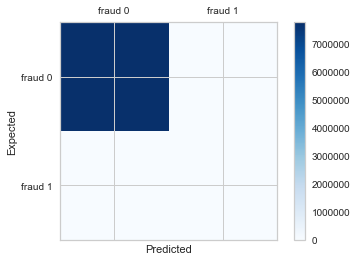

In [75]:
conf_matrix = confusion_matrix(y_true=y_test_2016, y_pred=pred_y)
print('Confusion matrix:\n', conf_matrix)

labels = ['fraud 0', 'fraud 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

## Reference

1. The imbalanced-learn documentation:
http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html

2. Comparison of the combination of over- and under-sampling algorithms:
http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/combine/plot_comparison_combine.html

3. Resampling strategies for imbalanced datasets
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

4. The Right Way to Oversample in Predictive Modeling
https://beckernick.github.io/oversampling-modeling/